In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import gymnasium as gym

%reload_ext autoreload
%autoreload 2

In [32]:
import pickle
import time
import sys
sys.path.append('../survey_ops/utils')
import ephemerides
import geometry
import units
sys.path.append('../survey_ops/src')
import environments
from offline_dataset import TelescopeDatasetv0
from agents import Agent
from algorithms import DDQN, BehaviorCloning

In [5]:
from pytorch_utils import seed_everything

# Load Data

In [6]:
import json
with open("../data/2013-09-15_gband_fields.json") as f:
    old_id2pos = json.load(f)

In [7]:
id2pos = {}
for key in old_id2pos.keys():
    id2pos[int(key)] = old_id2pos[key]

In [8]:
import pandas as pd
schedule = pd.read_csv('../data/2013-09-15_gband_schedule.csv', dtype={'next_field':'Int64'})

In [9]:
schedule_old = schedule.copy()

In [10]:
schedule_old

,time,field_id,next_field
0,1379248382,44,23
1,1379248544,23,53
2,1379248664,53,11
3,1379248794,11,16
4,1379248913,16,20
5,1379249032,20,54
6,1379249156,54,57
7,1379249275,57,33
8,1379249398,33,19
9,1379249529,19,9


In [11]:
field_id = 10
timestamp = schedule.iloc[field_id].time
field_ra, field_dec = id2pos[field_id]
field_az, field_el = ephemerides.equatorial_to_topographic(field_ra, field_dec, time=timestamp)
sun_ra, sun_dec = ephemerides.get_source_ra_dec("sun", time=timestamp)
sun_az, sun_el = ephemerides.equatorial_to_topographic(sun_ra, sun_dec, time=timestamp)
moon_ra, moon_dec = ephemerides.get_source_ra_dec("moon", time=timestamp)
moon_az, moon_el = ephemerides.equatorial_to_topographic(moon_ra, moon_dec, time=timestamp)

In [12]:
schedule.time

0     1379248382
1     1379248544
2     1379248664
3     1379248794
4     1379248913
5     1379249032
6     1379249156
7     1379249275
8     1379249398
9     1379249529
10    1379249655
11    1379249776
12    1379249894
13    1379250022
14    1379250146
15    1379250265
16    1379250385
17    1379250508
18    1379250625
19    1379250745
20    1379250873
21    1379250995
22    1379251113
23    1379251233
24    1379251365
25    1379251486
26    1379251606
27    1379251734
28    1379251865
29    1379251987
30    1379252114
31    1379252234
32    1379252355
33    1379252499
34    1379252624
35    1379252755
36    1379252874
37    1379252993
38    1379253125
39    1379253246
40    1379253371
41    1379253498
42    1379253618
43    1379253745
44    1379253870
45    1379253996
46    1379254115
47    1379254248
48    1379254367
49    1379254487
50    1379254607
51    1379254733
52    1379254855
53    1379254983
54    1379255103
55    1379255225
56    1379255345
57    1379255473
58    13792556

# Visualize schedule

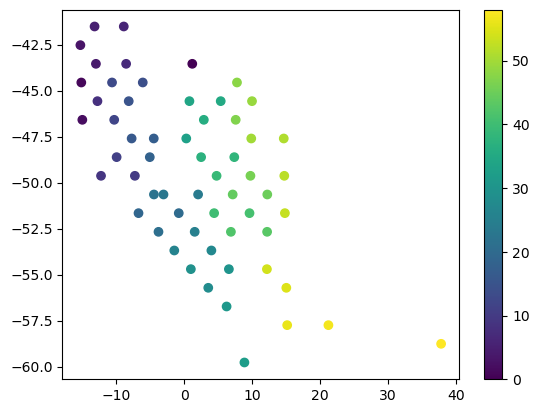

In [13]:

radec = np.array([id2pos[field_id] for field_id in schedule.field_id.values])
ra_shifted = np.where(radec[:, 0] > 180, radec[:, 0] - 360, radec[:, 0])
c = plt.scatter(ra_shifted, radec[:, 1], c = np.arange(len(ra_shifted)))
plt.colorbar(c)

# Configure dataset, model, and training setup

In [33]:
SEED = 10
train_size = 1


seed_everything(SEED)

torch.set_default_dtype(torch.float32)

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [22]:
dataset = TelescopeDatasetv0(schedule, id2pos, normalize_obs=True)

In [23]:
np.prod(dataset.obs.shape[1:])

58

In [24]:
"""DESIRED Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 1e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 3000,
    'batch_size': 32,
    # 'learning_start': 
    }

env_name = 'TelescopeEnv-v0'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):

    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_unique={dataset._nfields}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)


agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_obs,
    'outdir': outdir
    }

agent = Agent(**agent_config)



In [25]:
from environments import TelescopeEnv_v0

env_name = 'TelescopeEnv-v0'

gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=TelescopeEnv_v0,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

# for eval step only
env_config = {
    'id': f"gymnasium_env/{env_name}",
    'dataset': dataset
}


env = gym.make(**env_config)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/SimpleTel-v0", num_envs=5, vectorization_mode='sync', Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)

from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


/home/rachel/miniconda3/envs/cosmo_ml/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment gymnasium_env/TelescopeEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


# Train

In [27]:
agent.fit()

{'num_epochs': 3000, 'batch_size': 32}

In [29]:
start_time = time.time()
"""Train"""
agent.fit(
    dataset=dataset,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(train_time)

  4%|█▍                                    | 206/5437 [00:00<00:05, 1031.27it/s]

Train step 0: Accuracy = 0.000, Loss = 4.0616
Train step 100: Accuracy = 0.188, Loss = 3.7820
Train step 200: Accuracy = 0.250, Loss = 2.7733


  9%|███▎                                  | 478/5437 [00:00<00:03, 1251.92it/s]

Train step 300: Accuracy = 0.500, Loss = 2.2556
Train step 400: Accuracy = 0.500, Loss = 1.8546
Train step 500: Accuracy = 0.531, Loss = 1.5163


 14%|█████▏                                | 751/5437 [00:00<00:03, 1310.33it/s]

Train step 600: Accuracy = 0.625, Loss = 1.3181
Train step 700: Accuracy = 0.750, Loss = 1.2112
Train step 800: Accuracy = 0.750, Loss = 1.0425


 22%|████████                             | 1176/5437 [00:00<00:03, 1386.80it/s]

Train step 900: Accuracy = 0.844, Loss = 0.6930
Train step 1000: Accuracy = 0.844, Loss = 0.8171
Train step 1100: Accuracy = 0.812, Loss = 0.6116


 27%|█████████▉                           | 1452/5437 [00:01<00:02, 1338.65it/s]

Train step 1200: Accuracy = 0.875, Loss = 0.5906
Train step 1300: Accuracy = 0.688, Loss = 0.5102
Train step 1400: Accuracy = 0.875, Loss = 0.5112


 32%|███████████▋                         | 1725/5437 [00:01<00:02, 1350.18it/s]

Train step 1500: Accuracy = 0.906, Loss = 0.3982
Train step 1600: Accuracy = 0.906, Loss = 0.4445
Train step 1700: Accuracy = 0.969, Loss = 0.4334


 37%|█████████████▋                       | 2006/5437 [00:01<00:02, 1376.21it/s]

Train step 1800: Accuracy = 0.938, Loss = 0.3623
Train step 1900: Accuracy = 0.938, Loss = 0.2990
Train step 2000: Accuracy = 0.969, Loss = 0.2385


 42%|███████████████▌                     | 2289/5437 [00:01<00:02, 1394.20it/s]

Train step 2100: Accuracy = 0.906, Loss = 0.2242
Train step 2200: Accuracy = 0.969, Loss = 0.3323
Train step 2300: Accuracy = 0.969, Loss = 0.2507


 47%|█████████████████▍                   | 2568/5437 [00:01<00:02, 1370.68it/s]

Train step 2400: Accuracy = 0.938, Loss = 0.2416
Train step 2500: Accuracy = 1.000, Loss = 0.1921
Train step 2600: Accuracy = 1.000, Loss = 0.2785


 52%|███████████████████▎                 | 2843/5437 [00:02<00:01, 1364.47it/s]

Train step 2700: Accuracy = 1.000, Loss = 0.1812
Train step 2800: Accuracy = 0.938, Loss = 0.2587
Train step 2900: Accuracy = 1.000, Loss = 0.1725


 60%|██████████████████████▏              | 3252/5437 [00:02<00:01, 1325.56it/s]

Train step 3000: Accuracy = 1.000, Loss = 0.0960
Train step 3100: Accuracy = 0.969, Loss = 0.1392
Train step 3200: Accuracy = 1.000, Loss = 0.0936


 65%|███████████████████████▉             | 3525/5437 [00:02<00:01, 1343.92it/s]

Train step 3300: Accuracy = 0.938, Loss = 0.1207
Train step 3400: Accuracy = 1.000, Loss = 0.0349
Train step 3500: Accuracy = 0.969, Loss = 0.2402


 70%|█████████████████████████▊           | 3799/5437 [00:02<00:01, 1347.54it/s]

Train step 3600: Accuracy = 1.000, Loss = 0.0965
Train step 3700: Accuracy = 1.000, Loss = 0.1345
Train step 3800: Accuracy = 1.000, Loss = 0.0841


 75%|███████████████████████████▋         | 4077/5437 [00:03<00:00, 1369.13it/s]

Train step 3900: Accuracy = 1.000, Loss = 0.1194
Train step 4000: Accuracy = 1.000, Loss = 0.0908
Train step 4100: Accuracy = 0.969, Loss = 0.1418


 80%|█████████████████████████████▋       | 4361/5437 [00:03<00:00, 1389.86it/s]

Train step 4200: Accuracy = 1.000, Loss = 0.1082
Train step 4300: Accuracy = 0.969, Loss = 0.1307
Train step 4400: Accuracy = 1.000, Loss = 0.0795


 85%|███████████████████████████████▌     | 4641/5437 [00:03<00:00, 1380.42it/s]

Train step 4500: Accuracy = 0.969, Loss = 0.0525
Train step 4600: Accuracy = 1.000, Loss = 0.0911
Train step 4700: Accuracy = 1.000, Loss = 0.0588


 93%|██████████████████████████████████▍  | 5066/5437 [00:03<00:00, 1382.45it/s]

Train step 4800: Accuracy = 1.000, Loss = 0.0366
Train step 4900: Accuracy = 1.000, Loss = 0.0355
Train step 5000: Accuracy = 1.000, Loss = 0.0665


 96%|███████████████████████████████████▍ | 5205/5437 [00:03<00:00, 1370.75it/s]

Train step 5100: Accuracy = 1.000, Loss = 0.0358
Train step 5200: Accuracy = 1.000, Loss = 0.0759
Train step 5300: Accuracy = 1.000, Loss = 0.0354


100%|█████████████████████████████████████| 5437/5437 [00:04<00:00, 1327.50it/s]

Train step 5400: Accuracy = 1.000, Loss = 0.0569
4.100282192230225


In [34]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

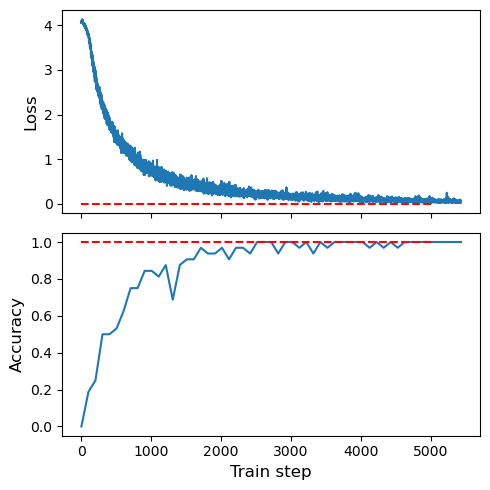

In [35]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=5000, color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=12)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=5000, color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=12)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].set_xlabel('Train step', fontsize=12)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Evaluate

In [36]:
agent.evaluate(env=env, num_episodes=1)
with open(outdir + 'eval_metrics.pkl', 'rb') as handle:
    eval_metrics = pickle.load(handle)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 91.25it/s]

terminated at 58
eval_metrics.pkl saved in ../results/None/


/tmp/ipykernel_129641/76053858.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


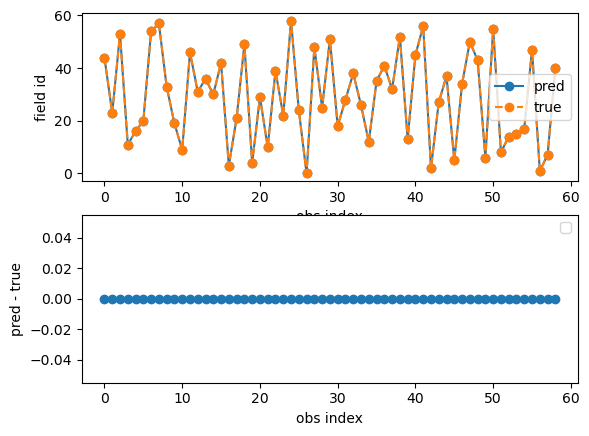

In [37]:
target_sequence = dataset._schedule_field_ids[0]
eval_sequence = eval_metrics['observations']['ep-0'][:, 0]

fig, axs = plt.subplots(2)
axs[0].plot(eval_sequence, marker='o', label='pred')
axs[0].plot(target_sequence, marker='o', linestyle='dashed', label='true')
axs[0].legend()
axs[0].set_xlabel('obs index')
axs[0].set_ylabel('field id')

axs[1].plot(eval_sequence - target_sequence, marker='o')
axs[1].legend()
axs[1].set_xlabel('obs index')
axs[1].set_ylabel('pred - true')


fig.savefig(outdir + 'learned_sequence.png')

In [46]:
with torch.no_grad():
    obs, expert_actions, rewards, next_obs, dones, action_masks = dataset.sample(25)
    print(obs.shape)
    action_logits = agent.algorithm.policy_net(torch.tensor(obs))
    action = torch.argmax(action_logits, dim=1)

(25, 2)


In [47]:
action_logits.shape

torch.Size([25, 59])

In [48]:
dataset.num_actions

59

In [49]:
action.shape

torch.Size([25])